<a href="https://colab.research.google.com/github/RonTeichner/IRAS/blob/main/IRAS_Ribosome_RQ_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IRAS utilized on the Ribosome Flow Model on a Ring**

### Ribosome model simulation
First we simulate the Ribosome Flow Model on a Ring,

$$
\begin{equation}
\begin{split}
\dot{x}_1 &= \lambda_n x_n (1-x_1) - \lambda_1 x_1 (1-x_2),\\
&\vdots\\
\dot{x}_i &= \lambda_{i-1} x_{i-1} (1-x_i) - \lambda_{i} x_{i} (1-x_{i+1}),\\
&\vdots\\
\dot{x}_n &= \lambda_{n-1} x_{n-1} (1-x_n) - \lambda_{n} x_{n} (1-x_{1}),
\end{split}
\end{equation}
$$

where $x \in \mathbb{R}^n$ is the state vector and $\lambda = \begin{bmatrix}\lambda_1 \dots \lambda_n\end{bmatrix}$ with every $\lambda_i>0$ is a vector of link capacities. Note that $\Sigma_{i=1}^n \dot{x}_i = 0$, implying that $\mathbf{1_n}'x(t) \equiv \mathbf{1_n}'x(0)$ where $\mathbf{1_n} \in \mathbb{R}^n$ is the vector with all entries one.



### IRAS output analysis

IRAS processes the discrete-time dataset $\mathbb{D} = \{z_k\}_{k=0}^{N-1}$ where $z_k = x(k t_s); \quad t_s=0.001$ and outputs a function $g: \mathbb{R}^n → \mathbb{R}$,

$$
\begin{equation}
g \leftarrow{} \mathrm{IRAS}(\mathbb{D}).
\end{equation}
$$

We will test whether IRAS identified the conserved quantity. We analyze the case where IRAS searches over a family of linear functions, $g(z;\theta)=\theta' z$.

First we define the dynamical system:

In [2]:
!pip install torchsde
import torch
from torch import nn
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchsde
from scipy import interpolate

class SDE_1D(nn.Module):

    def __init__(self, n):
        super().__init__()
        self.n = n
        self.lambdaVec = nn.Parameter(torch.tensor([2,5,5,0,1]), requires_grad=False)#[0.6, 0.3, 0.9]
        self.u_phi = nn.Parameter(torch.tensor(2*np.pi*np.random.rand(n)), requires_grad=False)
        self.u_amp = nn.Parameter(torch.tensor(0.5 + 0.25*np.random.rand(n)), requires_grad=False)
        self.u_f = nn.Parameter(torch.tensor(0.25 + 0.5*np.random.rand(n)), requires_grad=False)
        self.lambda_phi = nn.Parameter(torch.tensor(2*np.pi*np.random.rand(n)), requires_grad=False)
        self.lambda_amp = nn.Parameter(torch.tensor(0.0 + 0.0*np.random.rand(n)), requires_grad=False)
        self.lambda_f = nn.Parameter(torch.tensor(0.5 + 0.0*np.random.rand(n)), requires_grad=False)
        self.WienerGain = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, x):
        # x [batch_size, state_size]
        f_of_x = torch.zeros_like(x)

        lambdaVec = self.lambdaVec

        f_of_x[:,0] = lambdaVec[self.n-1]*x[:,self.n-1]*(1-x[:,0]) - lambdaVec[0]*x[:,0]*(1-x[:,1])

        for i in range(1,self.n-1):
            f_of_x[:,i] = lambdaVec[i-1]*x[:,i-1]*(1-x[:,i]) - lambdaVec[i]*x[:,i]*(1-x[:,i+1])

        f_of_x[:,self.n-1] = lambdaVec[self.n-2]*x[:,self.n-2]*(1-x[:,self.n-1]) - lambdaVec[self.n-1]*x[:,self.n-1]*(1-x[:,0])

        return f_of_x

    def g(self, t, x):
        return self.WienerGain*torch.ones_like(x)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

Generate a trajectory:

In [3]:
batch_size, state_size = 1, 5
t_step, sim_duration = 1e-3, 2 # [sec]
sde_list = [SDE_1D(state_size) for s in range(batch_size)]
ts = np.arange(0, sim_duration, t_step)
x0 = torch.tensor([[0.71, 0.9,  0.28, 0.8,  0.76]])

print(f'x0.shape = {x0.shape}')
sys.setrecursionlimit(5000)

with torch.no_grad():
    xs_list = [torchsde.sdeint(sde_list[i], x0[i:i+1], torch.from_numpy(ts), adaptive=True, dt=1e-3).cpu().numpy() for i in range(batch_size)]

xs = np.zeros((len(ts), batch_size, state_size))
for i in range(batch_size):
    xs[:,i] = xs_list[i][:,0]
#print(f'xs.shape = {xs.shape}')
print(r'$x^0 = $' + f' {x0.numpy()}')
print(r'$\lambda = $' + f' {sde_list[0].lambdaVec.numpy()}')

x0.shape = torch.Size([1, 5])
$x^0 = $ [[0.71 0.9  0.28 0.8  0.76]]
$\lambda = $ [2 5 5 0 1]


Let us view the trajectory,

In [4]:
def plot(ts, samples, xlabel, ylabel, title='', dots=False):
    nT, nSystems, nStates = samples.shape[0], samples.shape[1], samples.shape[2]
    plt.figure()#figsize=(20/1.5,5/1.5))
    for s in range(nSystems):
        systemSample = samples[:,s]
        plt.subplot(nSystems,1,s+1)
        conservationStr = r'$\frac{1}{3} \mathbf{1_3}^T z^{(s)} = $' + f'{str(round(systemSample[:len(ts)].mean(axis=1).mean(), 3))}' + r'$ \pm $'+ f'{str(round(systemSample[:len(ts)].mean(axis=1).std(), 3))}'
        if dots:
            plt.plot(ts, systemSample[:len(ts)].mean(axis=1), '.k', markersize=1.0, linewidth = 2.0, label=conservationStr)
        else:
            plt.plot(ts, systemSample[:len(ts)].mean(axis=1), 'k', linewidth = 2.0, label=conservationStr)
        for i in range(nStates):
            if dots:
                plt.plot(ts, systemSample[:len(ts),i], '.', markersize=1.0, linewidth = 1.0, label=f'z_{i}')
            else:
                plt.plot(ts, systemSample[:len(ts),i], linewidth = 1.0, label=f'z_{i}')
        #plt.title(title + f' ' + conservationStr)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        #plt.grid()
        plt.tight_layout()
        plt.show()


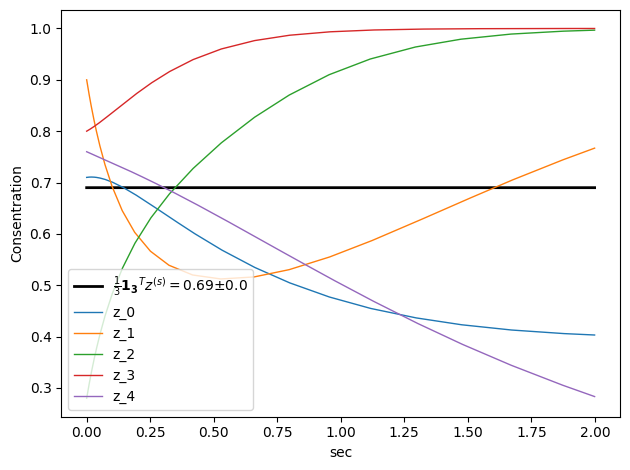

In [5]:
observations = xs
nSec2Plot = sim_duration
titleStr = ''
plot(ts[:int(nSec2Plot/t_step)], observations[:,:1], xlabel='sec', ylabel='Consentration', title=titleStr)

And now by adding additive noise and sampling we obtain the discrete-time observations:

sigEnergy = 0.017209674437447017
SNR = 6883.869774978806


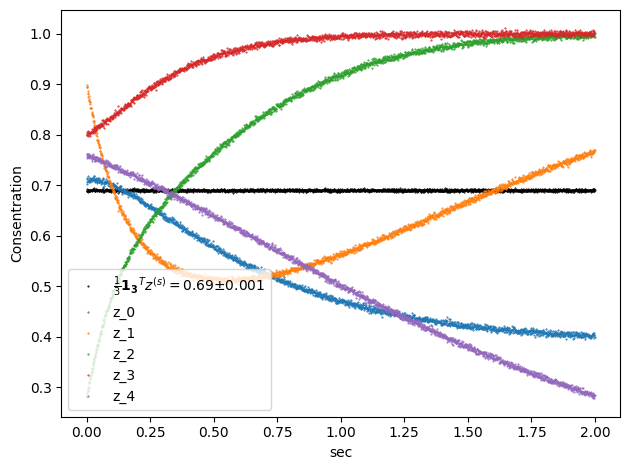

In [7]:
noiseEnergy = 0.00001
sigma_eta = np.sqrt(noiseEnergy)
#print(f'xs.shape = {xs.shape}')
#manualSigEnergy = np.power(np.linalg.norm(np.transpose(xs[:,0]) - np.repeat(xs[:,0].mean(axis=0)[:,None],xs.shape[0],1)), 2).mean()
#print(f'manualSigEnergy = {manualSigEnergy}')
#print(f'np.cov(np.transpose(xs[:,0])) = \n{np.cov(np.transpose(xs[:,0]))}')
sigEnergy = np.trace(np.cov(np.transpose(xs[:,0])))
print(f'sigEnergy = {sigEnergy/(state_size-1)}')
print(f'SNR = {sigEnergy/noiseEnergy}')
observations = xs + sigma_eta*np.random.randn(*xs.shape)


nSec2Plot = sim_duration
titleStr = ''
plot(ts[:int(nSec2Plot/t_step)], observations[:,:1], xlabel='sec', ylabel='Consentration', title=titleStr, dots=True)
observations = np.transpose(observations,(1,0,2))
observations_tVec = ts[None,:,None].repeat(observations.shape[0], 0)


The empirical covariance $\Sigma$ is calculated directly from the observed data,

In [8]:
data = np.transpose(np.reshape(observations, (observations.shape[0]*observations.shape[1],observations.shape[2])),(1,0))
Sigma = np.cov(data)
print(f'\Sigma = ')
with np.printoptions(precision=4, suppress=True, formatter={'float': '{:0.4f}'.format}, linewidth=100):
    print(Sigma)
print(f'tr(Sigma)={np.trace(Sigma)/2}')
print(f'bar sigma should be smaller than {(noiseEnergy+np.trace(Sigma)/2)/2}')

\Sigma = 
[[0.0096 -0.0023 -0.0160 -0.0048 0.0136]
 [-0.0023 0.0076 0.0012 -0.0004 -0.0061]
 [-0.0160 0.0012 0.0282 0.0087 -0.0220]
 [-0.0048 -0.0004 0.0087 0.0028 -0.0062]
 [0.0136 -0.0061 -0.0220 -0.0062 0.0207]]
tr(Sigma)=0.03445970878357673
bar sigma should be smaller than 0.017234854391788366


It's eigenvalues are,

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(Sigma)
print(f'{eigenvalues}')

[5.91762760e-02 9.56474031e-03 1.36538869e-04 9.81947071e-06
 3.20429021e-05]


and corresponding eigenvectors,

In [10]:
for i in range(eigenvectors.shape[0]):
    eigenvectors[:,i] = eigenvectors[:,i]/eigenvectors[0,i]
print(f'{eigenvectors}')

[[  1.           1.           1.           1.           1.        ]
 [ -0.24825839  79.95638953  -0.24318622   0.97996475  -0.88833823]
 [ -1.69008973 -32.12279411   0.23473889   0.98660703  -2.65722473]
 [ -0.50248879 -17.8793567   -0.41096267   0.98302071   4.80623331]
 [  1.44019296 -30.84637785  -0.60418804   0.97535247  -2.288865  ]]


At this point it is important to verify whether the spectrum of the covariance matrix matches the case analyzed in the paper.

We set $f_{\bar z} = \mathcal{N}(u, \bar \Sigma)$ where $u = \operatorname{E}[z]$, $\bar \Sigma = \bar \sigma^2 I_n$ and $\bar \sigma^2 = 10^{-5}$,

In [11]:
from scipy.linalg import fractional_matrix_power
sigma_bar = np.sqrt(2e-5)
mu = data.mean(axis=1)[:,None]
Sigma_bar = np.power(sigma_bar,2)*np.eye(data.shape[0])

z = data.copy()
Sigma_bar_half = np.real(fractional_matrix_power(Sigma_bar, 0.5))

And define the functions needed to run the RQ iterations,

In [12]:
import torch

def calc_dominant_eigenvector(Sigma, Sigma_tilde):
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sigma) @ Sigma_tilde)
    return eigenvectors[:,np.argmax(eigenvalues)]

def compute_comb_values(z, theta):
    return np.transpose(theta, (1,0)) @ z

def calc_Sigma_tilde(z, bar_z, theta, iteration=0):

    nBins = 100

    comb_shuffle_flatten = torch.tensor(compute_comb_values(bar_z, theta), dtype=torch.float)
    comb_data_flatten = torch.tensor(compute_comb_values(z, theta), dtype=torch.float)

    min_range = comb_data_flatten.min()
    max_range = comb_data_flatten.max()

    while np.logical_and(comb_shuffle_flatten > min_range, comb_shuffle_flatten < max_range).sum() < 0.1*len(comb_shuffle_flatten):
        min_range = 0.9*min_range
        max_range = 1.1*max_range

    bins = torch.linspace(min_range, max_range, nBins, device='cpu')
    prob_data = torch.histogram(comb_data_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]
    prob_shuffle = torch.histogram(comb_shuffle_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]

    binsDict = {'bins': bins, 'minVal': min_range, 'maxVal': max_range}

    bins, minVal, maxVal = binsDict['bins'], binsDict['minVal'], binsDict['maxVal']
    prob_select = torch.zeros_like(prob_data)

    posProbInx = prob_shuffle > 0
    #print(f'posProbInx.sum = {posProbInx.sum()}')
    prob_select[posProbInx] = prob_data[posProbInx]/prob_shuffle[posProbInx]
    prob_select[posProbInx] = prob_select[posProbInx]/prob_select[posProbInx].max()

    validIndices = torch.ones_like(comb_shuffle_flatten, device=comb_shuffle_flatten.device).bool()
    validIndices[comb_shuffle_flatten < minVal] = False
    validIndices[comb_shuffle_flatten > maxVal] = False

    bin_belong = torch.zeros_like(comb_shuffle_flatten, dtype=torch.long, device=comb_shuffle_flatten.device)
    for b in range(bins.shape[0]-1):
        bin_belong[comb_shuffle_flatten >= bins[b]] = b

    comb_shuffle_flatten_selectionProb = prob_select[bin_belong]
    comb_shuffle_flatten_selectionProb[torch.logical_not(validIndices)] = 0

    selection = torch.rand_like(comb_shuffle_flatten) < comb_shuffle_flatten_selectionProb
    selected_comb_shuffle_flatten = comb_shuffle_flatten[selection]
    tilde_z = bar_z[:, selection[0]]

    if not selection.any():
        print('selection is empty')

    if False:
        prob_smart = torch.histogram(selected_comb_shuffle_flatten.to('cpu'), bins=bins.to('cpu'), density=True)[0]

        plt.figure()
        plt.plot(bins.numpy()[:-1], prob_data.numpy(), label=r'$f_z$')
        plt.plot(bins.numpy()[:-1], prob_shuffle.numpy(), label=r'$f_{\bar z}$')
        plt.plot(bins.numpy()[:-1], prob_smart.numpy(), '--', label=r'$f_{\tilde z}$')
        plt.legend()
        plt.title(f'iteration {iteration}')
        plt.show()

    return np.cov(tilde_z)



Running 40 RQ-iterations  

theta_array[:,0] = [-0.1198443   0.19974051  0.40946804  0.75901392  0.44941614]
starting iter 10
starting iter 20
starting iter 30


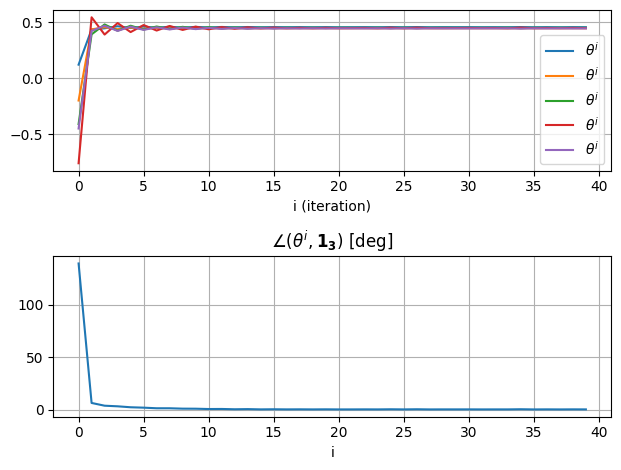

In [13]:
from scipy.linalg import fractional_matrix_power

N_iter = 40
theta_array = np.zeros((data.shape[0], N_iter))

N = int(1e6)
theta_array[:,0] = np.array([-0.12, 0.20, 0.41, 0.76, 0.45])
theta_array[:,0] = theta_array[:,0]/np.linalg.norm(theta_array[:,0])
print(f'theta_array[:,0] = {theta_array[:,0]}')

for i in range(1,N_iter):
    if np.mod(i,10) == 0:
        print(f'starting iter {i}')
    bar_z = np.repeat(mu,N,1) + Sigma_bar_half@np.random.randn(Sigma_bar_half.shape[0],N)
    #bar_z = Sigma_bar_half@np.random.randn(Sigma_bar_half.shape[0],N)
    Sigma_tilde = calc_Sigma_tilde(z.copy(), bar_z.copy(), theta_array[:,i-1:i], i-1)

    theta_array[:,i] = calc_dominant_eigenvector(Sigma, Sigma_tilde)

angles = np.zeros(N_iter)
v1 = np.ones(data.shape[0])
for i in range(N_iter):
    theta_array[:,i] = theta_array[:,i]/np.linalg.norm(theta_array[:,i])/np.sign(theta_array[0,i])
    angles[i] = np.arccos(np.dot(theta_array[:,i], v1)/np.linalg.norm(v1)/np.linalg.norm(theta_array[:,i]))

plt.figure()
plt.subplot(2,1,1)
for i in range(theta_array.shape[0]):
    plt.plot(theta_array[i,0:], label=r'$\theta^i$')
plt.xlabel('i (iteration)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(angles[0:]/np.pi*180)
plt.xlabel('i')
plt.title(r'$\angle(\theta^i,\mathbf{1_3})$ [deg]')
plt.grid()
plt.tight_layout()
plt.show()


Printing $\theta^i$ for the first 5 iterations:

In [14]:
theta_array[:,:5]

array([[ 0.1198443 ,  0.43370226,  0.4439299 ,  0.46240907,  0.44622711],
       [-0.19974051,  0.43461771,  0.45346176,  0.43594187,  0.45101141],
       [-0.40946804,  0.39011845,  0.47829654,  0.42230576,  0.46711746],
       [-0.75901392,  0.54208998,  0.38825805,  0.49060481,  0.41032887],
       [-0.44941614,  0.4206612 ,  0.46667631,  0.42082931,  0.45924022]])